In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, WeightedRandomSampler
from torchvision import transforms, utils
from torch.autograd import Variable

import numpy as np
import pandas as pd
import math, copy, time

import matplotlib.pyplot as plt

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from tqdm import trange
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import random
import re
from nltk.corpus import wordnet

#importing the model
from networks import *
#import helper util functions
from utils import do_syn_ant_augmentation, LogReader, LogTokenizer, get_data, get_padded_data, get_data_a
#importing the trainer, predictor and the loss
from trainer import run_train, run_test, SimpleLossCompute

torch.random.seed = 0
np.random.seed(0)

2022-08-29 10:14:23.698613: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-29 10:14:23.698636: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
#helper function to create the model --> the model is in networks.py
def make_model(src_vocab, tgt_vocab, N=3, 
               d_model=512, d_ff=2048, h=8, dropout=0.1, max_len=20):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout, max_len)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))
    
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

In [59]:
df = pd.read_csv('log_data_repository.csv').drop(["Unnamed: 0"], 1)
df = df[df.log_level!="debug"]

/tmp/ipykernel_23631/2247370369.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = pd.read_csv('log_data_repository.csv').drop(["Unnamed: 0"], 1)


In [61]:
df.head()

,log_message,log_level
0,This unittest can not run on Windows,warning
1,No send_alert_update method present for [STR],warning
2,multi bleu perl script returned non zero exit ...,warning
3,Saved model uses tensorflow version <*> but no...,warning
4,Weights named [STR] not found in network Skip it,warning


In [62]:
mappings = {"warning":0, "warn":0, "error":0, "log":1, "fatal":0, "trace":1, "critical":0, "exception": 0, "info": 1}
def level_to_binary(x):
    return mappings[x]


In [63]:
df['target'] = df.log_level.apply(lambda x: level_to_binary(x))

In [66]:
tokenizer = LogTokenizer()
df_len = int(df.shape[0])
data_tokenized = []
for i in trange(0, df_len):
    tokenized = tokenizer.tokenize(df.iloc[i].log_message)
    data_tokenized.append(tokenized)

100%|██████████| 763948/763948 [00:59<00:00, 12870.85it/s]


In [67]:
data_token_indexed = np.asanyarray(data_tokenized)

/tmp/ipykernel_23631/4156074377.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_token_indexed = np.asanyarray(data_tokenized)


In [70]:
ratio = 0.8
train_size = round(df_len * ratio)
train_size, df_len

(611158, 763948)

In [77]:
data_token_indexed_test = data_token_indexed[train_size:]
data_token_indexed_train = data_token_indexed[:train_size]

test_ground_labels = df.target.values[train_size:]
train_ground_labels = df.target.values[:train_size]

In [78]:
a = np.intersect1d(np.unique(data_token_indexed_test), np.unique(data_token_indexed_train), assume_unique=True)
#unique in test - intersection  
print("There are:",np.unique(data_token_indexed_test).shape[0] - a.shape[0],"unique log messages")

There are: 46522 unique log messages


In [79]:
batch_size = 2048
transform_to_tensor = transforms.Lambda(lambda lst: torch.tensor(lst))
train_data = TensorDataset(torch.tensor(get_padded_data(data_token_indexed_train, pad_len=50), dtype=torch.long), torch.tensor(train_ground_labels.astype(np.int32), dtype=torch.long))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

test_data = TensorDataset(torch.tensor(get_padded_data(data_token_indexed_test, pad_len=50), dtype=torch.long), torch.tensor(test_ground_labels.astype(np.int32).flatten(), dtype=torch.long))
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


In [81]:
class SimpleLossCompute:
    "A simple loss compute and train function."
    def __init__(self, model, criterion, opt=None, is_test=False):
        self.model = model
        self.criterion = criterion
        self.opt = opt
        self.is_test = is_test
        
    def __call__(self, x, y, dist):
        loss = torch.mean((1-y)*torch.sqrt(dist) - (y)*torch.log(1-torch.exp(-torch.sqrt(dist))))
        if not self.is_test:
            loss.backward()
            if self.opt is not None:
                self.opt.step()
                self.opt.zero_grad()

        return loss.item()

In [83]:
def run_train(dataloader, model, loss_compute, step_size=10):
    "Standard Training and Logging Function"
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    z = []
    for i, batch in enumerate(dataloader):
        b_input, b_labels = batch
        z += b_input[0]
        
        out = model.forward(b_input.cuda(), b_labels.cuda(), None, None)
        dist = torch.sum((out[:,0,:] - model.c) ** 2, dim=1)
        loss = loss_compute(out, b_labels.cuda(), dist)
        total_loss += loss
        
        if i % step_size == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d / %d Loss: %f" %
                    (i, len(dataloader), loss))
            start = time.time()
            tokens = 0
    return total_loss, z

In [86]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.8,1.0]).cuda())
model = make_model(tokenizer.n_words, 2, N=2, h=2, d_model=16, d_ff=16, dropout=0.05, max_len=50)
model.cuda()
model_opt = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=0.001)
max_auc = 0.0
max_distances = 0
for epoch in range(30):
    #training
    model.train()
    print("Epoch",epoch)
    run_train(train_dataloader, model, 
             SimpleLossCompute(model, criterion, model_opt), step_size=100)
    torch.save(model.state_dict(), '../output/models/model_'+str(epoch)+'.pt')
    
    
    #test
    model.eval()
    preds, distances = run_test(test_dataloader, model, 
                        SimpleLossCompute(model, criterion, None, is_test=True), step_size=100)

    preds = np.array(preds)
    auc = roc_auc_score(test_ground_labels.astype(np.int32), distances)
    print("AUC:", auc)
    if auc > max_auc:
        max_auc = auc
        fpr, tpr, thresholds = roc_curve(test_ground_labels.astype(np.int32), distances, pos_label=1)
        np.save(str(aux_size)+'_without8020.npy',[fpr, tpr, thresholds])
        print(roc_auc_score(test_ground_labels.astype(np.int32), distances))
        max_distances = distances
    

AssertionError: Torch not compiled with CUDA enabled

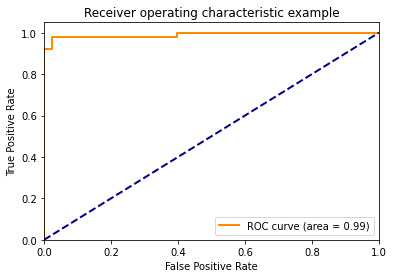

In [42]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_score(test_ground_labels.astype(np.int32), max_distances))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()